In [1]:
from fastai.tabular.all import *
from scipy.stats import norm
import pandas as pd
import numpy as np
import sys, os

import seaborn as sns
import matplotlib.pyplot as plt

/home/zquantz/anaconda3/lib/python3.7/site-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at  /opt/conda/conda-bld/pytorch_1607370156314/work/c10/cuda/CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0


### DataGen

In [2]:
def bs_price(S, K, T, r, q, v, t):
    
    d1 = np.log(S / K) + (r + 0.5 * v * v) * T
    d1 /= np.sqrt(T) * v
    d2 = d1 - np.sqrt(T) * v
    
    d1 *= t
    d2 *= t
    
    return t * S * np.exp(-q * T) * norm.cdf(d1) - t * K * np.exp(-r * T) * norm.cdf(d2)

rates = np.log(1 + np.arange(0, 2e-1, 0.001))
rmin, rmax = rates.min(), rates.max()

divs = np.log(1 + np.arange(0, 2e-1, 0.001))
qmin, qmax = divs.min(), divs.max()

stock_prices = np.arange(1, 200, 1)
strike_prices = np.arange(50, 150, 1)

time_to_expiries = np.arange(1, 1000, 1)
tmin, tmax = time_to_expiries.min(), time_to_expiries.max()

implied_volatilities = np.arange(5e-2, 1.25, 0.0005).tolist()
implied_volatilities += np.arange(1.25, 5, 0.05).tolist()
implied_volatilities = np.array(implied_volatilities)

types = np.array([1, -1])

data = [
    rates,
    divs,
    stock_prices,
    strike_prices,
    time_to_expiries,
    implied_volatilities,
    types
]

mods = np.array([
    len(d)
    for d in data
]).reshape((1, -1))
idc = np.random.randint(0, mods.max(), size=(750_000, len(data)))
idc = idc % mods

rates = rates[idc[:, 0]]
divs = divs[idc[:, 1]]
stock_prices = stock_prices[idc[:, 2]]
strike_prices = strike_prices[idc[:, 3]]
time_to_expiries = time_to_expiries[idc[:, 4]]
implied_volatilities = implied_volatilities[idc[:, 5]]
types = types[idc[:, 6]]
prices = bs_price(
    stock_prices,
    strike_prices,
    time_to_expiries / 252,
    rates,
    divs,
    implied_volatilities,
    types
)

rdata = pd.DataFrame(np.array([
    stock_prices,
    strike_prices,
    time_to_expiries,
    rates,
    divs,
    implied_volatilities,
    types,
    prices
]).T, columns = [
    'S',
    'K',
    'TT',
    'r',
    'q',
    'v',
    't',
    'p'
])
rdata = rdata[rdata.p > 0]

### Preprocess

In [3]:
rdata['M'] = np.log(rdata.S / rdata.K)

x = rdata.t * (rdata.S - rdata.K)
x[x < 0] = 0
rdata['tv'] = rdata.p - x
rdata['rtv'] = rdata.tv / rdata.K

x = rdata.t.values
x[x < 0] = 0
rdata['t'] = x

x = (rdata.TT - tmin) / (tmax - tmin)
x[x > 1] = 1
rdata['TT'] = x

rdata['r'] = (rdata.r - rmin) / (rmax - rmin)
rdata['q'] = (rdata.q - qmin) / (qmax - qmin)

cols = [
    "M",
    "TT",
    "r",
    "q",
    "t",
    "rtv",
    "v"
]
rdata = rdata[cols]

### Real Data

In [4]:
options = pd.read_csv("data/options.csv")
options['mid_price'] = (options.ask_price + options.bid_price) / 2

cols = [
    'stock_price',
    'strike_price',
    'tdays_to_expiry',
    'rate',
    'dividend_yield',
    'option_type',
    'mid_price',
    'bivs'
]
odata = options[cols]
odata = odata[odata.bivs < 10]
odata = odata[odata.tdays_to_expiry > 0]
odata = odata.reset_index(drop=True)

odata['M'] = np.log(odata.stock_price / odata.strike_price)

odata['r'] = np.log(1 + odata.rate / 100)
x = (odata.r - rmin) / (rmax - rmin)
x[x > 1] = 1
odata['r'] = x

odata['q'] = np.log(1 + odata.dividend_yield / 100)
x = (odata.q - qmin) / (qmax - qmin)
x[x > 1] = 1
odata['q'] = x

x = (odata.tdays_to_expiry - tmin) / (tmax - tmin)
x[x > 1] = 1
odata['TT'] = x

omap = odata.option_type.map({"C" : 1, "P" : -1})
x = omap * (odata.stock_price - odata.strike_price)
x[x < 0] = 0
x = odata.mid_price - x
odata['rtv'] = x / odata.strike_price

odata['v'] = odata.bivs

omap[omap < 0] = 0
odata['t'] = omap

cols = [
    "M",
    "TT",
    "r",
    "q",
    "t",
    "rtv",
    'v'
]
odata = odata[cols]

In [5]:
splits = RandomSplitter(valid_pct=0.35)(range_of(odata))
dls = TabularDataLoaders.from_df(
    df=rdata,
    y_names='v',
    splits=splits,
    bs=1024
)

In [6]:
dls.show_batch()

,TT,r,t,rtv,M,q,v
0,0.876754,0.614594,0.0,6.006795e-03,0.130053,0.168216,0.1515
1,0.978958,0.579986,0.0,2.368983e-07,0.587787,0.707448,0.1035
2,0.702405,0.986196,0.0,1.585359e-01,0.390539,0.963113,0.6495
3,0.525050,0.141430,0.0,1.139230e-06,0.751134,0.372800,0.1260
4,0.461924,0.146797,0.0,6.561115e-02,-1.057790,0.413843,0.9960
5,0.089178,0.226693,0.0,4.639041e-03,-1.178655,0.995403,0.1250
6,0.855711,0.336635,0.0,4.308416e-01,0.301924,0.194873,0.9325
7,0.288577,0.205500,0.0,-3.016158e-02,-1.013315,0.157517,0.1560
8,0.375751,0.367648,0.0,2.085095e-01,0.652325,0.750891,0.8430
9,0.126253,0.087462,0.0,6.317153e-03,-1.394878,0.648986,0.4785


In [7]:
learn = tabular_learner(
    dls,
    metrics=mse,
    layers=[400, 400, 400, 400],
    cbs=[
        SaveModelCallback()
    ]
)

In [8]:
def convert_act_cls(model, layer_type_old, layer_type_new):
    conversion_count = 0
    for name, module in reversed(model._modules.items()):
        if len(list(module.children())) > 0:
            # recurse
            model._modules[name] = convert_act_cls(module, layer_type_old, layer_type_new)

        if type(module) == layer_type_old:
            layer_old = module
            layer_new = layer_type_new
            model._modules[name] = layer_new

    return model

learn.model = convert_act_cls(learn.model, torch.nn.ReLU, Mish())

SuggestedLRs(lr_min=0.0009120108559727668, lr_steep=0.0002290867705596611)

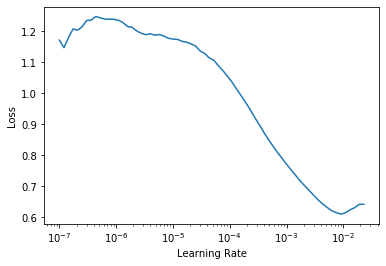

In [9]:
learn.lr_find()

In [11]:
learn.lr = 10e-4
learn.lr

0.001

In [ ]:
learn.fit_flat_cos(3000)

epoch,train_loss,valid_loss,mse,time
0,0.053154,0.050540,0.050540,00:35
1,0.042111,0.038911,0.038911,00:35
2,0.038895,0.032087,0.032087,00:34
3,0.036821,0.033984,0.033984,00:35
4,0.035739,0.031048,0.031048,00:35
5,0.033110,0.030853,0.030853,00:35
6,0.030400,0.028041,0.028041,00:35
7,0.030492,0.027851,0.027851,00:34
8,0.030730,0.029013,0.029013,00:35
9,0.029096,0.026963,0.026963,00:35


Better model found at epoch 0 with valid_loss value: 0.050540272146463394.
Better model found at epoch 1 with valid_loss value: 0.03891080617904663.
Better model found at epoch 2 with valid_loss value: 0.03208690136671066.
Better model found at epoch 4 with valid_loss value: 0.031047742813825607.
Better model found at epoch 5 with valid_loss value: 0.030852582305669785.
Better model found at epoch 6 with valid_loss value: 0.028040558099746704.
Better model found at epoch 7 with valid_loss value: 0.02785145677626133.
Better model found at epoch 9 with valid_loss value: 0.026963070034980774.
Better model found at epoch 10 with valid_loss value: 0.0246246587485075.
Better model found at epoch 11 with valid_loss value: 0.023876655846834183.
Better model found at epoch 13 with valid_loss value: 0.023701922968029976.
Better model found at epoch 22 with valid_loss value: 0.021966781467199326.
Better model found at epoch 25 with valid_loss value: 0.020420579239726067.
Better model found at epo

In [16]:
learn.show_results(max_n=50)

,moneyness,time_value,tdays_to_expiry,rate,dividend_yield,bivs,bivs_pred
0,-3.075007,-0.715632,3.361352,-0.447148,-0.029515,0.190456,0.185896
1,-1.073542,0.569311,-0.773707,-0.619393,0.230047,1.170717,1.170600
2,1.750374,1.683053,2.120835,-0.357519,0.230047,0.308992,0.325810
3,0.642952,0.634937,0.068073,-0.452128,-0.029515,0.286729,0.300642
4,0.379855,0.984542,0.149298,-0.366308,0.230047,0.264779,0.290681
5,-0.791354,-0.880523,-0.803243,-0.672116,-0.860967,0.277982,0.273130
6,0.159719,-0.562708,-0.751555,-0.604497,-0.600998,0.241025,0.247530
7,0.950763,-0.808647,-0.662946,-0.432233,0.230047,0.331750,0.340917
8,-1.280958,-0.854415,0.260058,2.048085,-0.237255,0.117882,0.118519
9,1.350481,-0.195584,0.223138,-0.538900,-0.600998,0.317833,0.314331


In [15]:
learn = learn.load("best")

In [16]:
train_preds, _ = learn.get_preds(ds_idx=0)
valid_preds, _ = learn.get_preds(ds_idx=1)

In [17]:
train_preds

tensor([[ 2810.7375],
        [10537.5391],
        [  944.4824],
        ...,
        [ 7242.1528],
        [10589.4854],
        [ 4134.0771]])

In [18]:
valid_preds

tensor([[ 5322.4429],
        [10127.6162],
        [ 2068.3933],
        ...,
        [14704.9473],
        [10931.5078],
        [ 2150.0981]])